In [3]:
from pathlib import Path
from typing import Dict

import mre
import numpy as np
import pandas as pd
import seaborn as sns

from tomato.audio.pitchdistribution import PitchDistribution

from matplotlib import pyplot as plt

from sklearn.model_selection import cross_validate, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

%load_ext autoreload
%autoreload 2


## helper functions

In [4]:
def bhat(v1, v2):
    return -np.log(np.sum(np.sqrt(v1 * v2)))


In [5]:
def prepare_dataset(annotations, pcd_files, pcd_tags):
    NUM_BINS = int(1200 / float(pcd_tags["step_size"]))
    
    # prepare features
    X = np.zeros((len(annotations.data), NUM_BINS))
    mbids = np.array([])
    for ii, pf in enumerate(pcd_files):
        vals = PitchDistribution.from_json(pf).vals
        if len(vals) != NUM_BINS:
            raise ValueError(
                "%s has %d bins instead of %d."
                % (pf, len(vals), NUM_BINS)
            )
        X[ii, :] = PitchDistribution.from_json(pf).vals
        mbids = np.append(mbids, Path(pf).stem)

    y = annotations.data.set_index("mbid").loc[mbids].makam.values

    return mre.data.dataset.Dataset(X, y)


# Read data

## Annotations

In [6]:
annotations = mre.data.Annotation.from_mlflow()
display(annotations.head())

,dunya_uid,makam,mb_url,mbid,observations,tonic,verified
0,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,Acemasiran,http://musicbrainz.org/recording/00f1c6d9-c8ee...,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,,256.0,False
1,168f7c75-84fb-4316-99d7-acabadd3b2e6,Acemasiran,http://musicbrainz.org/recording/168f7c75-84fb...,168f7c75-84fb-4316-99d7-acabadd3b2e6,,115.2,False
2,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,Acemasiran,http://musicbrainz.org/recording/24f549dd-3fa4...,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,,232.5,False
3,407bb0b4-f19b-42ab-8c0a-9f1263126951,Acemasiran,http://musicbrainz.org/recording/407bb0b4-f19b...,407bb0b4-f19b-42ab-8c0a-9f1263126951,,233.5,False
4,443819eb-6092-420c-bd86-d946a0ad6555,Acemasiran,http://musicbrainz.org/recording/443819eb-6092...,443819eb-6092-420c-bd86-d946a0ad6555,,219.6,False


## Pitch Class Distributions

In [7]:
pcd_files = mre.data.PitchClassDistribution.from_mlflow()
pcd_tags = mre.data.PitchClassDistribution.get_tags()


# Prepare inputs

In [8]:
dataset = prepare_dataset(annotations, pcd_files, pcd_tags)
print(dataset)


Dataset with 1000 samples and 48 feature dimensions.


# Experimental Setup

In [18]:
NUM_TRIALS = 10  # Number of random trials
CROSS_VALIDATION_TECHNIQUES = {
    "stratified_random_split_cv": {
        "num_splits": 1
    },
    "stratified_shuffle_split_cv": {
        "num_splits": 10
    },
    "stratified_10_fold_cv": {
        "num_splits": 10
    },
    "nested_stratified_10_fold_cv": {
        "num_splits": 10
    }
}
ARCHITECTURES = [
#     'LogisticRegression': {
#         "name": "LogisticRegression",
#         "estimator": LogisticRegression(max_iter=100, solver="saga"),
#         "param_grid": {
#             "penalty": ["l2", 'l1'],
#             "C": [0.1, 1, 10]
#         }
#     },
#     'DecisionTree': {
#         "name": "DecisionTree",
#         "estimator": DecisionTreeClassifier(),
#         "param_grid": {
#             "criterion": ["gini", "entropy"],
#             "max_depth": [5, 10, 25, 50]
#         }
#     },
    mre.experimentation.Architecture(
        name="KNN",
        estimator=KNeighborsClassifier(),
        param_grid={
            "n_neighbors": [1, 3],
            "weights": ["uniform", "distance"],
            "metric": ["manhattan", "euclidean"]
#             "metric": [bhat, "manhattan", "euclidean"]
        }
    ),
    mre.experimentation.Architecture(
        name="SVM",
        estimator=SVC(kernel="rbf"),
        param_grid={
            "C": [100, 1000],  # .001, .01, .1, 1, 10 give worse results, omitted
            "gamma": [.1, 1]  # .001, .01 give worse results, omitted
        }
    ),
#     'RandomForest': {
#         "name": "RandomForest",
#         "estimator": RandomForestClassifier(),
#         "param_grid": {
#             "n_estimators": [5, 10, 25, 50],
#             "criterion": ["gini", "entropy"],
#             "max_depth": [5, 10, 25, 50]
#         }
#     },
#     "mlp": {
#         "name": "MultiLayerPerceptron",
#         "estimator": MLPClassifier(momentum=0.5, max_iter=10000, learning_rate_init=0.001),
#         "param_grid": {
#             "hidden_layer_sizes": [75, 100, 150, 200],
#             "alpha": [0.1, 0.01, 0.001]
#         }
#     },
]


## Nested 10 fold

In [29]:
nested_stratified_10_fold_cv_experiment = mre.experimentation.NestedStratified10FoldCV(
    num_splits=10, num_trials=10
)

nested_stratified_10_fold_cv_experiment.run(dataset, ARCHITECTURES)
nested_stratified_10_fold_cv_experiment.results.head()

   KNN, Test acc: 0.66∓0.06, Train acc: 1.00∓0.00, Max fit time: 4.2 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
   SVM, Test acc: 0.72∓0.04, Train acc: 0.81∓0.00, Max fit time: 3.4 sec, Best Params: {'C': 100, 'gamma': 1}
   KNN, Test acc: 0.64∓0.04, Train acc: 1.00∓0.00, Max fit time: 3.5 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
   SVM, Test acc: 0.71∓0.04, Train acc: 0.82∓0.02, Max fit time: 3.3 sec, Best Params: {'C': 100, 'gamma': 1}
   KNN, Test acc: 0.64∓0.04, Train acc: 1.00∓0.00, Max fit time: 4.2 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
   SVM, Test acc: 0.71∓0.04, Train acc: 0.82∓0.03, Max fit time: 3.8 sec, Best Params: {'C': 100, 'gamma': 1}
   KNN, Test acc: 0.65∓0.04, Train acc: 1.00∓0.00, Max fit time: 4.2 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
   SVM, Test acc: 0.72∓0.04, Train acc: 0.81∓0.01, Max fit tim

,architecture,best_params_,cv_results_,fit_time,score_time,split_id,test_score,train_score,trial_id
0,KNN,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...","{'mean_fit_time': [0.04466860294342041, 0.0477...",4.003536,0.009815,0,0.67,1.0,0
1,KNN,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...","{'mean_fit_time': [0.03785054683685303, 0.0550...",4.044551,0.035030,1,0.70,1.0,0
2,KNN,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...","{'mean_fit_time': [0.03657889366149902, 0.0477...",3.733701,0.053733,2,0.61,1.0,0
3,KNN,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...","{'mean_fit_time': [0.038138818740844724, 0.063...",4.011400,0.017460,3,0.60,1.0,0
4,KNN,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...","{'mean_fit_time': [0.03232426643371582, 0.0449...",3.594045,0.031847,4,0.68,1.0,0


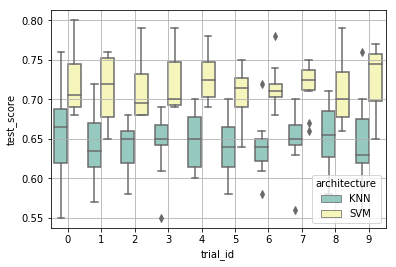

In [27]:
ax = sns.boxplot(
    x="trial_id",
    y="test_score",
    hue="architecture",
    data=nested_scores,
    palette="Set3"
)
plt.grid()


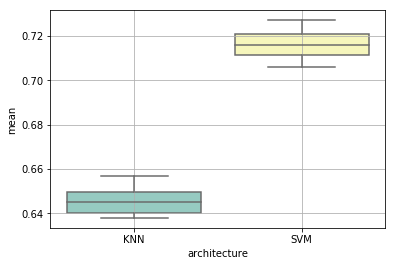

In [28]:
ax = sns.boxplot(
    x="architecture",
    y="mean",
    data=nested_scores.groupby(["trial_id", "architecture"])["test_score"].agg(["mean", "std"]).reset_index(),
    palette="Set3"
)
plt.grid()


## 10 fold

In [ ]:
def run_stratified_k_fold_cv(
    architectures: Dict,
    cv_technique: int,
    num_trials: int
) -> pd.DataFrame:
    VERBOSE = 0
    N_JOBS = -1
    scores = []
    for ii in range(num_trials):
        print(f"Trial {ii}")
        n_splits = cv_technique["num_splits"]
        outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=ii)

        for arch in architectures.values():
            clf = GridSearchCV(
                estimator=arch["estimator"],
                param_grid=arch["param_grid"],
                cv=outer_cv,
                return_train_score=True,
                verbose=VERBOSE,
                n_jobs=N_JOBS
            )
            clf.fit(X, y)

            results = clf.cv_results_
            best_index = clf.best_index_
            for ns in range(n_splits):
                scores.append({
                    "architecture": arch["name"],
                    "train_score": results[f"split{ns}_train_score"][best_index],
                    "test_score": results[f"split{ns}_test_score"][best_index],
                    "fit_time": results["mean_fit_time"][best_index],
                    "score_time": results["mean_score_time"][best_index],
                    "split_id": ns,
                    "trial_id": ii,
                    "best_params_": clf.best_params_,
                    "cv_results_": clf.cv_results_
                })
            
            print(
                f'  {arch["name"]:<18}, '
                f'Mean/std test acc : {results["mean_test_score"][best_index]:.2f}∓{results["std_test_score"][best_index]:.2f}, '
                f'Mean/std train acc: {results["mean_train_score"][best_index]:.2f}∓{results["std_train_score"][best_index]:.2f}, '
                f'Max fit time: {max(results["mean_fit_time"]):.1f} sec, '
                f'Best Params: {clf.best_params_}'
            )
    
    return pd.DataFrame(scores)


In [ ]:
kfold_scores = run_stratified_k_fold_cv(
    architectures=ARCHITECTURES,
    cv_technique=CROSS_VALIDATION_TECHNIQUES["stratified_10_fold_cv"],
    num_trials=NUM_TRIALS
)


In [ ]:
ax = sns.boxplot(
    x="trial_id",
    y="test_score",
    hue="architecture",
    data=kfold_scores,
    palette="Set3"
)
plt.grid()


In [ ]:
ax = sns.boxplot(
    x="architecture",
    y="mean",
    data=kfold_scores.groupby(["trial_id", "architecture"])["test_score"].agg(["mean", "std"]).reset_index(),
    palette="Set3"
)
plt.grid()


## 10-times shuffle split

In [ ]:
def run_shuffle_cv(
    architectures: Dict,
    cv_technique: int,
    num_trials: int
) -> pd.DataFrame:
    VERBOSE = 0
    N_JOBS = -1
    nested_scores = []
    for ii in range(num_trials):
        print(f"Trial {ii}")
        n_splits = cv_technique["num_splits"]

        # 80 train, 20 (validation + test)
        outer_cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=ii)
        
        # 10 validation, 10 test
        inner_cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=ii)

        for arch in architectures.values():
            clf = GridSearchCV(
                estimator=arch["estimator"],
                param_grid=arch["param_grid"],
                cv=inner_cv,
                verbose=VERBOSE,
                n_jobs=N_JOBS
            )

            scores = cross_validate(
                clf,
                X=X,
                y=y,
                cv=outer_cv,
                verbose=VERBOSE,
                n_jobs=N_JOBS,
                return_estimator=True,
                return_train_score=True
            )

            for ns in range(n_splits):
                nested_scores.append({
                    "architecture": arch["name"],
                    "train_score": scores["train_score"][ns],
                    "test_score": scores["test_score"][ns],
                    "fit_time": scores["fit_time"][ns],
                    "score_time": scores["score_time"][ns],
                    "split_id": ns,
                    "trial_id": ii,
                    "best_params_": scores["estimator"][ns].best_params_,
                    "cv_results_": scores["estimator"][ns].cv_results_
                })
            best_params_str = [str(est.best_params_) for est in scores["estimator"]]
            most_common_best_params = max(best_params_str, key=best_params_str.count)
            
            print(
                f'   {arch["name"]:<20}, '
                f'Mean/std test acc : {np.mean(scores["test_score"]):.2f}∓{np.std(scores["test_score"]):.2f}, '
                f'Mean/std train acc: {np.mean(scores["train_score"]):.2f}∓{np.std(scores["train_score"]):.2f}, '
                f'Max fit time: {max(scores["fit_time"]):.1f} sec, '
                f'Best Params: {most_common_best_params}'
            )

    return pd.DataFrame(nested_scores)


In [ ]:
shuffle_scores = run_shuffle_cv(
    architectures=ARCHITECTURES,
    cv_technique=CROSS_VALIDATION_TECHNIQUES["stratified_shuffle_split_cv"],
    num_trials=NUM_TRIALS
)


In [ ]:
ax = sns.boxplot(
    x="trial_id",
    y="test_score",
    hue="architecture",
    data=shuffle_scores,
    palette="Set3"
)
plt.grid()


In [ ]:
ax = sns.boxplot(
    x="architecture",
    y="mean",
    data=shuffle_scores.groupby(["trial_id", "architecture"])["test_score"].agg(["mean", "std"]).reset_index(),
    palette="Set3"
)
plt.grid()


## Single shuffled split

In [ ]:
random_scores = run_shuffle_cv(
    architectures=ARCHITECTURES,
    cv_technique=CROSS_VALIDATION_TECHNIQUES["stratified_random_split_cv"],
    num_trials=NUM_TRIALS
)


In [ ]:
ax = sns.boxplot(
    x="architecture",
    y="mean",
    data=random_scores.groupby(["trial_id", "architecture"])["test_score"].agg(["mean", "std"]).reset_index(),
    palette="Set3"
)
plt.grid()


# Evaluate different shallow architectures under different experimental setups